<a href="https://colab.research.google.com/github/Muslimah123/Applied/blob/main/Idaya_Seidu_HW3P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

hw_3_p_2_automatic_speech_recognition_asr_11_785_path = kagglehub.competition_download('hw-3-p-2-automatic-speech-recognition-asr-11-785')
hidayaseidu_checkpoints_other_default_1_path = kagglehub.model_download('hidayaseidu/checkpoints/Other/default/1')
hidayaseidu_some_other_default_1_path = kagglehub.model_download('hidayaseidu/some/Other/default/1')

print('Data source import complete.')


# Speech Recognition with Neural Networks: Utterance to Phoneme Mapping


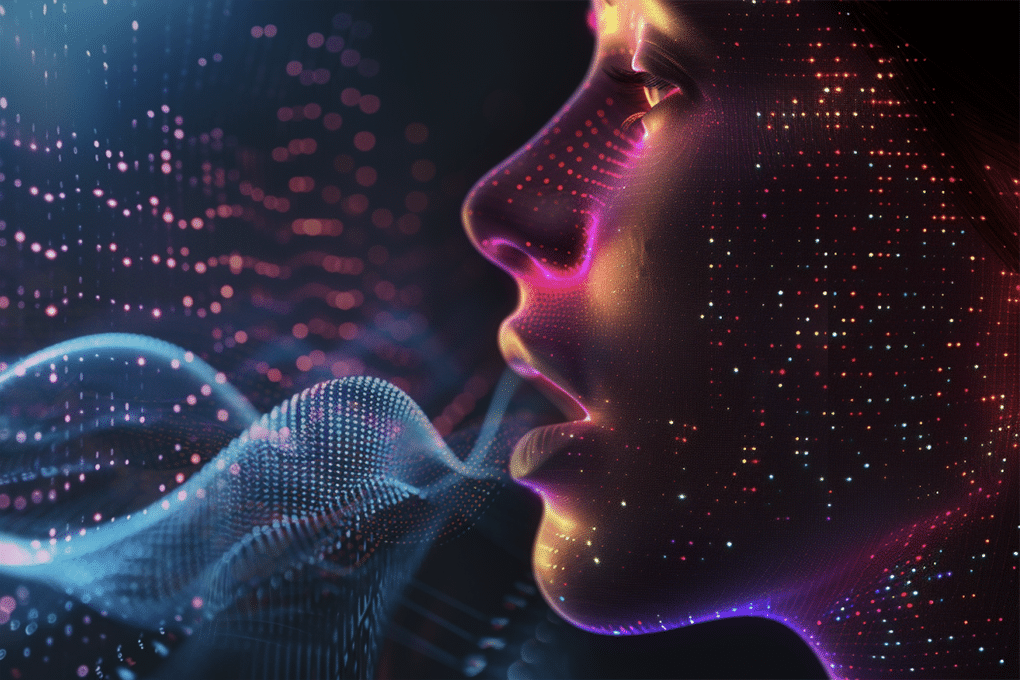

In this assignment, you'll build a sequence-to-sequence model that maps speech utterances to phoneme sequences. You'll implement a recurrent neural network architecture that processes speech feature vectors (MFCCs) and outputs corresponding phoneme sequences.

## Key Components

- **Data Processing**: Work with Mel-Frequency Cepstral Coefficients (MFCCs) and handle variable-length sequences through padding and packing
- **Neural Network Architecture**: Implement a model using basic CNNs for feature extraction, BiLSTMs for sequential modeling, and optional pyramidal BiLSTMs for downsampling
- **CTC Loss**: Train your model using Connectionist Temporal Classification to handle sequence alignment challenges
- **Decoding Strategies**: Explore both greedy search and beam search for phoneme sequence generation
- **Evaluation**: Use Levenshtein Distance to measure the accuracy of your predicted phoneme sequences
- **Submission**: Submit your results on kaggle for final evaluation.

This assignment will give you practical experience with sequence modeling techniques essential to speech recognition systems while exploring various architectural choices and optimization strategies.

# Installs

In [ ]:
!pip install torchinfo --quiet
!pip install python-Levenshtein --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 4.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.6 MB/s eta 0:00:00a 0:00:01


## Imports

In [ ]:
import torch
import random
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import wandb
import torchaudio.transforms as tat
from torchaudio.models.decoder import cuda_ctc_decoder
import Levenshtein

from sklearn.metrics import accuracy_score
import gc

import glob

import zipfile
from tqdm.auto import tqdm
import os
import datetime


import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


# Google Drive

In [ ]:
# Uncomment this if you want to use Google Drive
# from google.colab import drive
# drive.mount('/content/gdrive')

# Kaggle API Setup

In [ ]:
# !pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
# !mkdir /root/.kaggle

# with open("/root/.kaggle/kaggle.json", "w+") as f:

#     f.write('{"username":"hidayaseidu","key":"65cd13d62154350a9c7198fe1f0a08b9"}') # Put your kaggle username & key here

# !chmod 600 /root/.kaggle/kaggle.json

### Download Data (Chill out it will take a while😀)

In [ ]:
# !pip install --upgrade --force-reinstall --no-deps kaggle
# !kaggle competitions download -c hw-3-p-2-automatic-speech-recognition-asr-11-785 # Download Data
# !unzip -q hw-3-p-2-automatic-speech-recognition-asr-11-785.zip    # Unzip the dataset...

# Config

In [ ]:
%%writefile config.yaml

# Subset of dataset to use (1.0 == 100% of data)
subset: 1.0
learning_rate: 0.001
epochs: 2
train_beam_width: 3
test_beam_width: 10
mfcc_features: 28 # DO NOT MODIFY

# Set embedding size (the dimensionality of the LSTM hidden state)
embed_size: 256   # {64,128,256} Try out higher embed_size if you have powerfull GPU(RAM) other than T4

batch_size: 128 # Increase if your device can handle it

encoder dropout: 0.2
lstm dropout: 0.2
decoder dropout: 0.2
wandb: True # Set to True if you want to use WanDB

Name: "Idaya Seidu" # Write your name here

Writing config.yaml


In [ ]:
import yaml
with open("config.yaml") as file:
    config = yaml.safe_load(file)

In [ ]:
config

{'subset': 1.0,
 'learning_rate': 0.001,
 'epochs': 2,
 'train_beam_width': 3,
 'test_beam_width': 10,
 'mfcc_features': 28,
 'embed_size': 256,
 'batch_size': 128,
 'encoder dropout': 0.2,
 'lstm dropout': 0.2,
 'decoder dropout': 0.2,
 'wandb': True,
 'Name': 'Idaya Seidu'}

In [ ]:
BATCH_SIZE = config["batch_size"] # Define batch size from config
root = "/kaggle/input/hw-3-p-2-automatic-speech-recognition-asr-11-785/11785-S25-hw3p2" # Specify the directory to your root based on your environment

# Setup Vocabulary (DO NOT MODIFY)

In [ ]:
# ARPABET PHONEME MAPPING
# DO NOT CHANGE

CMUdict_ARPAbet = {
    "" : " ",
    "[SIL]": "-", "NG": "G", "F" : "f", "M" : "m", "AE": "@",
    "R"    : "r", "UW": "u", "N" : "n", "IY": "i", "AW": "W",
    "V"    : "v", "UH": "U", "OW": "o", "AA": "a", "ER": "R",
    "HH"   : "h", "Z" :
     "z", "K" : "k", "CH": "C", "W" : "w",
    "EY"   : "e", "ZH": "Z", "T" : "t", "EH": "E", "Y" : "y",
    "AH"   : "A", "B" : "b", "P" : "p", "TH": "T", "DH": "D",
    "AO"   : "c", "G" : "g", "L" : "l", "JH": "j", "OY": "O",
    "SH"   : "S", "D" : "d", "AY": "Y", "S" : "s", "IH": "I",
    "[SOS]": "[SOS]", "[EOS]": "[EOS]"
}


CMUdict = list(CMUdict_ARPAbet.keys())
ARPAbet = list(CMUdict_ARPAbet.values())

PHONEMES = CMUdict[:-2] #To be used for mapping original transcripts to integer indices
LABELS = ARPAbet[:-2] #To be used for mapping predictions to strings

OUT_SIZE = len(PHONEMES) # Number of output classes
print("Number of Phonemes:", OUT_SIZE)

# Indexes of BLANK and SIL phonemes
BLANK_IDX=CMUdict.index('')
SIL_IDX=CMUdict.index('[SIL]')

print("Index of Blank:", BLANK_IDX)
print("Index of [SIL]:", SIL_IDX)

Number of Phonemes: 41
Index of Blank: 0
Index of [SIL]: 1


### Sample data inspection & sanity check

In [ ]:
test_mfcc = f"{root}/train-clean-100/mfcc/103-1240-0000.npy"
test_transcript = f"{root}/train-clean-100/transcript/103-1240-0000.npy"

mfcc = np.load(test_mfcc)
transcript = np.load(test_transcript)[1:-1] #Removed [SOS] and [EOS]

print("MFCC Shape:", mfcc.shape)
print("\nMFCC:\n", mfcc)
print("\nTranscript shape:", transcript.shape)

print("\nOriginal Transcript:\n", transcript)

# map the loaded transcript (from phonemes representation) to corresponding labels representation
mapped_transcript = [CMUdict_ARPAbet[k] for k in transcript]
print("\nTranscript mapped from PHONEMES representation to LABELS representation:\n", mapped_transcript)

# Mapping list of PHONEMES to list of Integer indexes
map = {k: i for i, k in enumerate(PHONEMES)}
print("\nMapping list of PHONEMES to list of Integer indexes:\n", map)



MFCC Shape: (1404, 28)

MFCC:
 [[ 1.10582151e+01  1.28330450e+01  2.10689220e+01 ... -8.75406042e-02
   7.30623007e-02  9.48924713e+01]
 [ 1.16850815e+01  1.38329487e+01  2.19087906e+01 ... -1.39180899e-01
  -6.15991093e-02  9.55670319e+01]
 [ 1.11048431e+01  1.67276516e+01  2.28863831e+01 ... -4.03698802e-01
   8.09250996e-02  9.54314651e+01]
 ...
 [ 2.62413955e+00 -1.26996317e+01  2.79472313e+01 ... -1.49060452e+00
  -2.67574161e-01  1.16191261e+02]
 [ 3.05713993e-02 -1.20763254e+01  2.60116520e+01 ... -8.54688883e-01
  -1.20284989e-01  1.17127373e+02]
 [-1.33604801e+00 -1.17101593e+01  2.44703121e+01 ... -9.30283189e-01
  -8.16672146e-02  1.18280014e+02]]

Transcript shape: (145,)

Original Transcript:
 ['[SIL]' 'CH' 'AE' 'P' 'T' 'ER' 'W' 'AH' 'N' '[SIL]' 'M' 'IH' 'S' 'IH' 'Z'
 'R' 'EY' 'CH' 'AH' 'L' 'IH' 'N' 'D' 'IH' 'Z' 'S' 'ER' 'P' 'R' 'AY' 'Z'
 'D' '[SIL]' 'M' 'IH' 'S' 'IH' 'Z' 'R' 'EY' 'CH' 'AH' 'L' 'IH' 'N' 'D'
 '[SIL]' 'L' 'AY' 'V' 'D' '[SIL]' 'JH' 'AH' 'S' 'T' 'W' 'EH' 'R' '

# Dataset and Dataloader

### Train Data

In [ ]:

class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir="train-clean-100"):
        """
        Initializes the dataset.

        Args:
            data_dir: Path to the data directory (e.g., 'train-clean-100', 'dev-clean')
        """
        self.PHONEMES = PHONEMES
        self.subset = config['subset']

        # Define the directories containing MFCC and transcript files
        self.mfcc_dir = f"{root}/{data_dir}/mfcc"
        self.transcript_dir = f"{root}/{data_dir}/transcript"

        # List all files in the directories. Remember to sort the files
        self.mfcc_files = sorted(glob.glob(f"{self.mfcc_dir}/*.npy"))
        self.transcript_files = sorted(glob.glob(f"{self.transcript_dir}/*.npy"))

        # Print to debug
        print(f"Found {len(self.mfcc_files)} MFCC files in {self.mfcc_dir}")

        # Compute size of data subset
        subset_size = int(self.subset * len(self.mfcc_files))

        # Select subset of data to use
        self.mfcc_files = self.mfcc_files[:subset_size]
        self.transcript_files = self.transcript_files[:subset_size]

        assert(len(self.mfcc_files) == len(self.transcript_files))

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.mfcc_files)

    def __getitem__(self, idx):
        """
        Returns the MFCC coefficients and its corresponding labels.
        """
        # Load MFCC and transcript data
        mfcc = np.load(self.mfcc_files[idx])
        transcript = np.load(self.transcript_files[idx])[1:-1]  # Remove [SOS] and [EOS]

        # Normalize MFCC (instance normalization)
        mfcc = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1e-8)

        # Convert transcript phonemes to indices
        transcript_indices = [CMUdict.index(phoneme) for phoneme in transcript]

        # Convert to tensors
        mfcc = torch.FloatTensor(mfcc)
        transcript = torch.LongTensor(transcript_indices)

        return mfcc, transcript


### Test Data

In [ ]:
# # TODO
class AudioDatasetTest(torch.utils.data.Dataset):
    def __init__(self, data_dir="test-clean"):
        """
        Initializes the test dataset.
        """
        # Define the directory containing MFCC files
        self.mfcc_dir = f"{root}/{data_dir}/mfcc"

        # List all files in the directory. Remember to sort the files
        self.mfcc_files = sorted(glob.glob(f"{self.mfcc_dir}/*.npy"))

        # Print for debugging
        print(f"Found {len(self.mfcc_files)} test MFCC files in {self.mfcc_dir}")

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.mfcc_files)

    def __getitem__(self, idx):
        """
        Returns the MFCC coefficients.
        """
        # Load MFCC data
        mfcc = np.load(self.mfcc_files[idx])

        # Normalize MFCC (instance normalization)
        mfcc = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1e-8)

        # Convert to tensor
        mfcc = torch.FloatTensor(mfcc)

        return mfcc


In [ ]:
# To free up ram
import gc
gc.collect()

289

### Create Datasets & Data loaders

In [ ]:
# # Create objects for the dataset classes

train_data = AudioDataset(data_dir="train-clean-100")
val_data = AudioDataset(data_dir="dev-clean")  # Use the appropriate validation directory
test_data = AudioDatasetTest(data_dir="test-clean")

# Now let's define collate_fn as a standalone function
def collate_fn(batch):
    """
    Collate function for batching data.
    """
    # Extract batch of input MFCCs and output transcripts separately
    batch_mfcc = [item[0] for item in batch]
    batch_transcript = [item[1] for item in batch]

    # Store original lengths of the MFCCs and transcripts in the batches
    lengths_mfcc = [x.shape[0] for x in batch_mfcc]
    lengths_transcript = [x.shape[0] for x in batch_transcript]

    # Pad the MFCC sequences and transcripts
    batch_mfcc_pad = pad_sequence(batch_mfcc, batch_first=True)
    batch_transcript_pad = pad_sequence(batch_transcript, batch_first=True)

    # Return the following values: padded features, padded labels, actual length of features, actual length of the labels
    return batch_mfcc_pad, batch_transcript_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

def collate_fn_test(batch):
    """
    Collate function for test data.
    """
    # Extract lengths
    lengths_mfcc = [x.shape[0] for x in batch]

    # Pad sequences
    batch_mfcc_pad = pad_sequence(batch, batch_first=True)

    # Return padded features and their lengths
    return batch_mfcc_pad, torch.tensor(lengths_mfcc)



Found 28539 MFCC files in /kaggle/input/hw-3-p-2-automatic-speech-recognition-asr-11-785/11785-S25-hw3p2/train-clean-100/mfcc
Found 2703 MFCC files in /kaggle/input/hw-3-p-2-automatic-speech-recognition-asr-11-785/11785-S25-hw3p2/dev-clean/mfcc
Found 2620 test MFCC files in /kaggle/input/hw-3-p-2-automatic-speech-recognition-asr-11-785/11785-S25-hw3p2/test-clean/mfcc


In [ ]:
# Do NOT forget to pass in the collate function as an argument while creating the dataloader

train_loader = DataLoader(
    train_data,
    batch_size=config['batch_size'],
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_data,
    batch_size=config['batch_size'],
    shuffle=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_data,
    batch_size=config['batch_size'],
    shuffle=False,
    collate_fn=collate_fn_test
)

print("Batch size: ", config['batch_size'])
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  128
Train dataset samples = 28539, batches = 223
Val dataset samples = 2703, batches = 22
Test dataset samples = 2620, batches = 21


In [ ]:
# sanity check
for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, ly.shape)
    break

torch.Size([128, 1686, 28]) torch.Size([128, 207]) torch.Size([128]) torch.Size([128])


# Visualize Data

Note: In the visualized graph, do not confuse padded regions of the MFCC sequences with time/freq augmentation masks. Remember all MFCCs were padded to the maximum sequence length

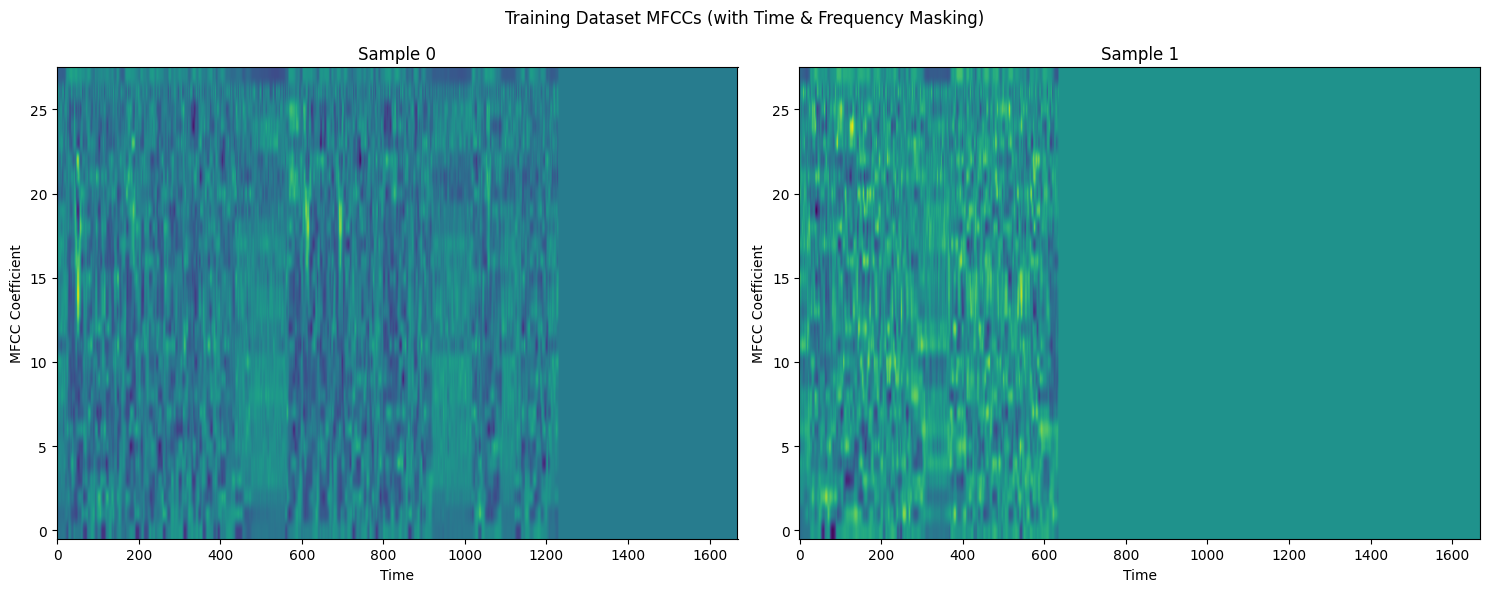

In [ ]:
import matplotlib.pyplot as plt

def visualize_batch(loader, title="Dataset Visualization", num_samples=2):
    """
    Visualizes MFCC features from a single batch of data.

    Args:
        loader (DataLoader): DataLoader object (for train, val, or test).
        title (str): Title of the plot.
        num_samples (int): Number of samples to visualize from the batch.
    """
    # Get one batch from the loader.
    batch = next(iter(loader))

    # The collate_fn we defined in the dataset class returns a tuple, where the first element is the padded MFCC tensor.
    mfcc_batch = batch[0] if isinstance(batch, (tuple, list)) else batch

    # Limit to a few samples.
    num_samples = min(num_samples, mfcc_batch.size(0))

    # Create subplots.
    fig, axes = plt.subplots(1, num_samples, figsize=(15,6))
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        # Each MFCC tensor is of shape [time, frequency].
        # Transpose for visualization: time on x-axis, features on y-axis.
        mfcc_img = mfcc_batch[i].cpu().numpy().T
        im = axes[i].imshow(mfcc_img, origin="lower", aspect="auto", cmap="viridis")
        axes[i].set_title(f"Sample {i}")
        axes[i].set_xlabel("Time")
        axes[i].set_ylabel("MFCC Coefficient")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize batches of data
visualize_batch(train_loader, title="Training Dataset MFCCs (with Time & Frequency Masking)")


# Network

## Basic network (Optional)

This is a basic block for understanding, you can skip this and move to pBLSTM one

In [ ]:
# torch.cuda.empty_cache()

# class Network(nn.Module):

#     def __init__(self):

#         super(Network, self).__init__()

#         # TODO: Adding some sort of embedding layer or feature extractor might help performance.
#         # You can use CNNs as Embedding layer to extract features. Keep in mind the Input dimensions and expected dimension of Pytorch CNN.
#         # Food for thought -> What type of Conv layers can be used here?
#         #                  -> What should be the size of input channels to the first layer?
#         self.embedding = _________________________ #TODO

#         # TODO : look up the documentation. You might need to pass some additional parameters.
#         self.lstm = nn.LSTM(input_size = __________________, hidden_size = 256, num_layers = 1) #TODO

#         self.classification = nn.Sequential(
#             #TODO: Linear layer with in_features from the lstm module above and out_features = OUT_SIZE
#         )


#         self.logSoftmax =__________________ #TODO: Apply a log softmax here. Which dimension would apply it on ?

#     def forward(self, x, lx):
#         #TODO
#         # The forward function takes 2 parameter inputs here. Why?
#         # Refer to the handout for hints
#         pass


## Initialize Basic Network
(If trying out the basic Network)

In [ ]:
# torch.cuda.empty_cache()

# model = Network().to(device)
# print(model)


## ASR Network
We define everything we need for the ASR model in separate classes, and put them all together in the end

#### Permute class

In [ ]:
class Permute(torch.nn.Module):
    '''
    Used to transpose/permute the dimensions of an MFCC tensor.
    '''
    def forward(self, x):
        return x.transpose(1, 2)

#### Pyramidal Bi-LSTM (pBLSTM) class

#### Util for LSTM


In [ ]:

class pBLSTM(torch.nn.Module):
    """
    Pyramidal BiLSTM
    """
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()

        self.blstm = nn.LSTM(
            input_size=input_size * 2,  # Doubled because we concatenate adjacent frames
            hidden_size=hidden_size,
            bidirectional=True,
            batch_first=True
        )

    def forward(self, x_packed):
        # x_packed is a PackedSequence

        # Pad Packed Sequence
        x, x_lens = pad_packed_sequence(x_packed, batch_first=True)

        # Handle odd-length sequences
        if x.size(1) % 2 == 1:
            x = F.pad(x, (0, 0, 0, 1))  # Pad in time dimension
            # Adjust lengths for padded sequences
            x_lens = [length + (1 if length % 2 == 1 else 0) for length in x_lens]
            x_lens = torch.tensor(x_lens, device=x.device)

        # Reshape x by concatenating adjacent frames
        batch_size, time_steps, feature_dim = x.size()
        x = x.contiguous().view(batch_size, time_steps // 2, feature_dim * 2)

        # Adjust sequence lengths accordingly
        x_lens = torch.div(x_lens, 2, rounding_mode='floor')

        # Pack Padded Sequence
        x_packed = pack_padded_sequence(x, x_lens.cpu(), batch_first=True, enforce_sorted=False)

        # Pass through BLSTM
        output_packed, _ = self.blstm(x_packed)

        return output_packed



In [ ]:
class LSTMWrapper(torch.nn.Module):
    '''
    Used to get only output of lstm, not the hidden states.
    '''
    def __init__(self, lstm):
        super(LSTMWrapper, self).__init__()
        self.lstm = lstm

    def forward(self, x):
        output, _ = self.lstm(x)
        return output

#### Encoder class

In [ ]:
class Encoder(torch.nn.Module):
    """
    The Encoder takes utterances as inputs and returns latent feature representations
    """
    def __init__(self, input_size, encoder_hidden_size):
        super(Encoder, self).__init__()

        # Get dropout values from config or use defaults
        lstm_dropout = config.get('lstm_dropout', 0.2)

        # Calculate hidden sizes to ensure they are integers
        hidden_size_1 = int(encoder_hidden_size * 1.89)  # Convert to int
        hidden_size_2 = int(encoder_hidden_size * 1.89)  # Convert to int

        # CNN feature extractor
        self.embedding = nn.Sequential(
            Permute(),
            nn.Conv1d(input_size, encoder_hidden_size, kernel_size=5, padding=2),
            nn.BatchNorm1d(encoder_hidden_size),
            nn.ReLU(),
            nn.Conv1d(encoder_hidden_size, encoder_hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(encoder_hidden_size),
            nn.ReLU(),
            Permute()
        )

        # BiLSTM layers
        self.blstm = LSTMWrapper(
            nn.LSTM(
                input_size=encoder_hidden_size,
                hidden_size=encoder_hidden_size,
                bidirectional=True,
                num_layers=2,
                batch_first=True,
                dropout=lstm_dropout
            )
        )

        # Pyramidal BiLSTM layers - now using integer hidden sizes
        self.pblstms = nn.Sequential(
            pBLSTM(input_size=encoder_hidden_size*2, hidden_size=hidden_size_1),
            pBLSTM(input_size=hidden_size_1*2, hidden_size=hidden_size_2)
        )

    def forward(self, x, x_lens):
        # Apply feature extraction via CNN
        x = self.embedding(x)

        # Pack the sequences for LSTM
        x_packed = pack_padded_sequence(x, x_lens.cpu(), batch_first=True, enforce_sorted=False)

        # Pass through BiLSTM
        x_packed = self.blstm(x_packed)

        # Pass through pBLSTM layers
        encoder_outputs = self.pblstms(x_packed)

        # Unpack outputs
        encoder_outputs, encoder_lens = pad_packed_sequence(encoder_outputs, batch_first=True)

        return encoder_outputs, encoder_lens

#### Decoder class

In [ ]:

class Decoder(torch.nn.Module):
    """
    The Decoder takes encoded utterances and outputs phoneme probabilities
    """
    def __init__(self, embed_size, output_size=41):
        super(Decoder, self).__init__()

        # Calculate the encoder output size based on the same formula
        encoder_output_size = int(embed_size * 1.89) * 2  # 1.5x hidden size × 2 for bidirectional

        # MLP for classification
        self.mlp = nn.Sequential(
            Permute(),
            nn.Conv1d(encoder_output_size, embed_size*2, kernel_size=3, padding=1),
            nn.BatchNorm1d(embed_size*2),
            nn.ReLU(),
            nn.Conv1d(embed_size*2, embed_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(embed_size),
            nn.ReLU(),
            Permute(),
            nn.Linear(embed_size, output_size)
        )

        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, encoder_out):
        # Apply MLP
        output = self.mlp(encoder_out)

        # Apply log softmax
        log_probs = self.softmax(output)

        return log_probs

#### ASR Model Class

In [ ]:
class ASRModel(torch.nn.Module):
    def __init__(self, input_size=28, embed_size=256, output_size=len(PHONEMES)):
        super(ASRModel, self).__init__()

        # Initialize encoder and decoder
        self.encoder = Encoder(input_size=input_size, encoder_hidden_size=embed_size)
        self.decoder = Decoder(embed_size=embed_size, output_size=output_size)

    def forward(self, x, lengths_x):
        # Pass through encoder
        encoder_out, encoder_lens = self.encoder(x, lengths_x)

        # Pass through decoder
        decoder_out = self.decoder(encoder_out)

        return decoder_out, encoder_lens

## Initialize ASR Network

In [ ]:
# Print config values for debugging
print("Config values:")
for key, value in config.items():
    print(f"  {key}: {value}")

# Set default values if not present
if 'lstm_dropout' not in config:
    config['lstm_dropout'] = 0.2
    print("Added default lstm_dropout: 0.2")


model = ASRModel(
    input_size=28,  # MFCC features
    embed_size=config['embed_size'],  # Hidden dimension
    output_size=len(PHONEMES)  # Number of phoneme classes
).to(device)


Config values:
  subset: 1.0
  learning_rate: 0.001
  epochs: 2
  train_beam_width: 3
  test_beam_width: 10
  mfcc_features: 28
  embed_size: 256
  batch_size: 128
  encoder dropout: 0.2
  lstm dropout: 0.2
  decoder dropout: 0.2
  wandb: True
  Name: Idaya Seidu
Added default lstm_dropout: 0.2


In [ ]:
# summary(model, input_data=[x.to(device), lx.to(device)])
summary(model, input_data=[torch.zeros(2, 100, 28).to(device), torch.tensor([100, 80]).to(device)])

Layer (type:depth-idx)                   Output Shape              Param #
ASRModel                                 [2, 25, 41]               --
├─Encoder: 1-1                           [2, 25, 966]              --
│    └─Sequential: 2-1                   [2, 100, 256]             --
│    │    └─Permute: 3-1                 [2, 28, 100]              --
│    │    └─Conv1d: 3-2                  [2, 256, 100]             36,096
│    │    └─BatchNorm1d: 3-3             [2, 256, 100]             512
│    │    └─ReLU: 3-4                    [2, 256, 100]             --
│    │    └─Conv1d: 3-5                  [2, 256, 100]             196,864
│    │    └─BatchNorm1d: 3-6             [2, 256, 100]             512
│    │    └─ReLU: 3-7                    [2, 256, 100]             --
│    │    └─Permute: 3-8                 [2, 100, 256]             --
│    └─LSTMWrapper: 2-2                  [180, 512]                --
│    │    └─LSTM: 3-9                    [180, 512]                2,629,6

# Training Config
Initialize Loss Criterion, Optimizer, CTC Beam Decoder, Scheduler, Scaler (Mixed-Precision), etc

In [ ]:
# Define CTC loss
criterion = nn.CTCLoss(
    blank=BLANK_IDX,  # Blank index (should be 0)
    reduction='mean',
    zero_infinity=True  # Helps with numerical stability
)

# Define optimizer with learning rate from config
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=1e-5  # Small weight decay for regularization
)

# Define learning rate scheduler (optional)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True
)

# Beam decoder for inference
decoder = cuda_ctc_decoder(
    tokens=LABELS,
    nbest=1,
    beam_size=config['test_beam_width']
)

# Mixed Precision, if you need it
scaler = torch.cuda.amp.GradScaler()

### Decode Prediction

In [ ]:

def decode_prediction(output, output_lens, decoder, PHONEME_MAP=LABELS):
    """
    Decode the output of the model using beam search.
    """
    # Get contiguous outputs for the decoder
    output = output.contiguous()
    output_lens = output_lens.to(torch.int32).contiguous()

    # Run the decoder
    beam_results = decoder(output, output_lens)

    pred_strings = []

    for i in range(len(beam_results)):
        # Get the top prediction for each sequence in the batch
        top_beam_results = beam_results[i][0].tokens

        # Convert prediction from indices to actual phoneme LABELS
        pred_string = ''.join([PHONEME_MAP[idx] for idx in top_beam_results])
        pred_strings.append(pred_string)

    return pred_strings

def calculate_levenshtein(output, label, output_lens, label_lens, decoder, PHONEME_MAP=LABELS):
    """
    Calculate Levenshtein distance between predictions and targets.
    """
    dist = 0
    batch_size = label.shape[0]

    # Get predictions using beam search
    pred_strings = decode_prediction(output, output_lens, decoder, PHONEME_MAP)

    for i in range(batch_size):
        # Get actual label string
        label_length = label_lens[i].item()
        label_indices = label[i, :label_length].tolist()
        label_string = ''.join([PHONEME_MAP[idx] for idx in label_indices])

        # Calculate Levenshtein distance
        dist += Levenshtein.distance(pred_strings[i], label_string)

    # Average the distance over the batch
    dist /= batch_size
    return dist

In [ ]:
torch.cuda.empty_cache()
gc.collect()

7119

## Test Implementation

In [ ]:
# test code to check shapes

model.eval()
for i, data in enumerate(val_loader, 0):
    x, y, lx, ly = data
    x, y = x.to(device), y.to(device)
    lx, ly = lx.to(device), ly.to(device)
    h, lh = model(x, lx)
    print(h.shape)
    h = torch.permute(h, (1, 0, 2))
    print(h.shape, y.shape)
    loss = criterion(h, y, lh, ly)
    print(loss)

    print(calculate_levenshtein(torch.permute(h, (1, 0, 2)), y, lh.to(device), ly, decoder, LABELS))

    del x, y, lx, ly, h, lh, loss
    torch.cuda.empty_cache()

    break

torch.Size([128, 734, 41])
torch.Size([734, 128, 41]) torch.Size([128, 265])
tensor(7.1488, device='cuda:0', grad_fn=<MeanBackward0>)
62.1796875


## WandB

In [ ]:
# Use wandb? Resume Training?
USE_WANDB = config['wandb']
RESUME_LOGGING = False # Set this to true if you are resuming training from a previous run

# Create your wandb run
run_name = '{}_early_submission'.format(config['Name'])

# If you are resuming an old run
if USE_WANDB:
    wandb.login(key="13cc0a2954e4d8ab50b199bc73019bb60f34f445")

    if RESUME_LOGGING:
        run = wandb.init(
            id      = "", ### Insert specific run id here if you want to resume a previous run
            resume  = "must", ### You need this to resume previous runs
            project = "hw3p2-ablations", ### Project should be created in your wandb
            settings = wandb.Settings(_service_wait=300)
        )
    else:
        run = wandb.init(
            name    = "Idaya_tests", ### Added quotes to make it a string
            reinit  = True, ### Allows reinitalizing runs when you re-run this cell
            project = "hw3p2-ablations", ### Project should be created in your wandb account
            config  = config ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)
        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()
        ### log it in your wandb run with wandb.save()
        wandb.save('model_arch.txt')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: iseidu (team64). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Training Functions

In [ ]:
# Train function

def train_model(model, train_loader, criterion, optimizer):
    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    total_loss = 0

    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        x, y, lx, ly = data
        x, y = x.to(device), y.to(device)
        lx, ly = lx.to(device), ly.to(device)

        with torch.cuda.amp.autocast():
            h, lh = model(x, lx)

            # Apply permute to match CTC loss requirements: [T, N, C]
            h = torch.permute(h, (1, 0, 2))

            # Compute CTC loss
            loss = criterion(h, y, lh, ly)

        total_loss += loss.item()

        # Update progress bar
        batch_bar.set_postfix(
            loss=f"{loss.item():.04f}",
            lr=f"{optimizer.param_groups[0]['lr']:.06f}"
        )
        batch_bar.update()

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        # Update weights
        optimizer.step()

        # Free up memory
        del x, y, lx, ly, h, lh, loss
        torch.cuda.empty_cache()

    batch_bar.close()
    return total_loss / len(train_loader)

def validate_model(model, val_loader, criterion, decoder, phoneme_map=LABELS):
    model.eval()
    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Val')

    total_loss = 0
    vdist = 0

    for i, data in enumerate(val_loader):
        x, y, lx, ly = data
        x, y = x.to(device), y.to(device)
        lx, ly = lx.to(device), ly.to(device)

        with torch.inference_mode():
            h, lh = model(x, lx)

            # Apply permute to match CTC loss requirements: [T, N, C]
            h_permuted = torch.permute(h, (1, 0, 2))

            # Compute CTC loss
            loss = criterion(h_permuted, y, lh, ly)

            # Calculate Levenshtein distance
            dist = calculate_levenshtein(h, y, lh.to(device), ly, decoder, phoneme_map)

        total_loss += loss.item()
        vdist += dist

        # Update progress bar
        batch_bar.set_postfix(
            loss=f"{loss.item():.04f}",
            dist=f"{dist:.04f}"
        )
        batch_bar.update()

        # Free up memory
        del x, y, lx, ly, h, lh, loss
        torch.cuda.empty_cache()

    batch_bar.close()
    return total_loss / len(val_loader), vdist / len(val_loader)

### Model Saving & Loading functions

In [ ]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict() if scheduler is not None else {},
         metric[0]                  : metric[1],
         'epoch'                    : epoch},
         path
    )

def load_model(path, model, optimizer= None, scheduler= None, metric='valid_dist'):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    epoch   = checkpoint['epoch']
    metric  = checkpoint[metric]

    print("\nResuming training from epoch:", epoch)
    print('----------------------------------------\n')
    print("Epochs left: ", config['epochs'] - epoch)
    print("Optimizer: \n", optimizer)
    print("Current Schedueler T_cur:", scheduler.T_cur)

    print("Best Val Dist:", metric)

    return [model, optimizer, scheduler, epoch, metric]

## Training Loop

In [ ]:
# Instantiate variables used in training loop
last_epoch_completed = 0
best_lev_dist = float("inf")

#### Uncomment this if resuming training from model checkpoint

In [ ]:
# RESUME_TRAINING = True # Set this to true if you are resuming training from a mpdel checkpoint

# if RESUME_TRAINING:

#     checkpoint_path = ''
#     checkpoint = load_model(checkpoint_path, model, optimizer, scheduler, metric='valid_dist')

#     last_epoch_completed = checkpoint[3]
#     best_lev_dist = checkpoint[4]

In [ ]:
# Set up checkpoint directories and WanDB logging watch
checkpoint_root = os.path.join(os.getcwd(), 'checkpoints')
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(model, log="all")

checkpoint_best_model_filename = 'checkpoint-best-model.pth'
checkpoint_last_epoch_filename = 'checkpoint-last-epoch.pth'
epoch_model_path = os.path.join(checkpoint_root, checkpoint_last_epoch_filename)
best_model_path = os.path.join(checkpoint_root, checkpoint_best_model_filename)

# WanDB log watch
if config['wandb']:
  wandb.watch(model, log="all")


In [ ]:
# Clear RAM for storage before you start training
torch.cuda.empty_cache()
gc.collect()

256

#### Iterate over the number of epochs to train and evaluate your model


In [ ]:
# #TODO: Please complete the training loop

# Main training loop
for epoch in range(last_epoch_completed, config['epochs']):
    print(f"\nEpoch: {epoch+1}/{config['epochs']}")

    # Train one epoch
    train_loss = train_model(model, train_loader, criterion, optimizer)

    # Validate
    valid_loss, valid_dist = validate_model(model, val_loader, criterion, decoder, LABELS)

    # Step the scheduler if used
    scheduler.step(valid_dist)

    print(f"\tTrain Loss {train_loss:.04f}\t Learning Rate {optimizer.param_groups[0]['lr']:.07f}")
    print(f"\tVal Dist {valid_dist:.04f}\t Val Loss {valid_loss:.04f}")

    # Save last epoch model
    save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, epoch_model_path)

    # Save best model if we got better validation score
    if valid_dist < best_lev_dist:
        best_lev_dist = valid_dist
        save_model(model, optimizer, scheduler, ['valid_dist', valid_dist], epoch, best_model_path)
        print("Saved best val model")

# Finish Wandb run
if config['wandb']:
    run.finish()


Epoch: 1/2


Train:   0%|          | 0/223 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

	Train Loss 3.3871	 Learning Rate 0.0010000
	Val Dist 61.3778	 Val Loss 4.1629
Saved best val model

Epoch: 2/2


Train:   0%|          | 0/223 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

	Train Loss 1.9241	 Learning Rate 0.0010000
	Val Dist 64.9522	 Val Loss 2.8541


# Generate Predictions and Submit to Kaggle

In [ ]:
#TODO: Make predictions

# Follow the steps below:
# 1. Create a new object for CUDA_CTC_DECODER with larger number of beams (why larger?)
# 2. Get prediction string by decoding the results of the beam decoder


# Make predictions
test_decoder = cuda_ctc_decoder(tokens=LABELS, nbest=1, beam_size=config['test_beam_width'])
results = []
model.eval()
print("Testing")
for data in tqdm(test_loader):
    x, lx = data
    x, lx = x.to(device), lx.to(device)
    with torch.no_grad():
        h, lh = model(x, lx)
    prediction_string = decode_prediction(h, lh.to(device), test_decoder, LABELS)

    # Add the predictions to our results list
    # We use extend instead of append because prediction_string is a list of predictions for each sample in the batch
    results.extend(prediction_string)

    del x, lx, h, lh
    torch.cuda.empty_cache()

# 1. First, load the best model checkpoint
# best_model_path = "/kaggle/input/some/other/default/1/checkpoint-best-model.pth"  # Update with your actual saved model path

# # Load the checkpoint
# checkpoint = torch.load(best_model_path)
# model.load_state_dict(checkpoint['model_state_dict'])

# # Print available information from the checkpoint
# print("Checkpoint keys:", list(checkpoint.keys()))

# # Print checkpoint info safely, handling missing keys
# epoch = checkpoint.get('epoch', 'unknown')
# print(f"Loaded model from epoch {epoch}")

# if 'metric' in checkpoint:
#     print(f"Validation distance: {checkpoint['metric']}")
# elif 'valid_dist' in checkpoint:
#     print(f"Validation distance: {checkpoint['valid_dist']}")
# else:
#     print("Validation metric not found in checkpoint")

Testing


  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
# # Create the beam decoder
# test_decoder = cuda_ctc_decoder(
#     tokens=LABELS,
#     nbest=1,
#     beam_size=config['test_beam_width']
# )

# # Run model on test data
# results = []
# model.eval()
# print("Testing...")

# for data in tqdm(test_loader):
#     x, lx = data
#     x, lx = x.to(device), lx.to(device)

#     with torch.no_grad():
#         h, lh = model(x, lx)

#     # Decode predictions using beam search
#     prediction_string = decode_prediction(h, lh.to(device), test_decoder, LABELS)

#     # Add the predictions to our results list
#     results.extend(prediction_string)

#     # Clean up memory
#     del x, lx, h, lh
#     torch.cuda.empty_cache()

In [ ]:
if results:
    df = pd.DataFrame({
        'index': range(len(results)), 'label': results
    })

data_dir = "early_submission2.csv"
df.to_csv(data_dir, index = False)

In [ ]:
# !kaggle competitions submit -c hw-3-p-2-automatic-speech-recognition-asr-11-785 -f /content/submission.csv -m "I made it! "